# Radar

Ovaj primer ilustruje primenu diskretne Furijeove transformacije u radu radara koji na osnovu 
prikupljenih podataka vizualizuje ciljani objekat (stenu).

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Podaci koje je radar prikupio se nalaze u `npz` (numpy gzip) arhivi. Ove vrste arhiva omogućavaju čuvanje kompresovanih nizova podataka. Za kreiranje arhive koriste se funkcije `save` i `savez`, u zavisnosti od toga da li se čuva vrednost jednog ili većeg broja nizova. Za učitavanje podataka koristi se funkcija `load`.

In [2]:
data = np.load('data/radar_scan.npz')

Možemo videti da se u arhivi nalazi tačno jedan niz sa imenom *scan*. Njega ćemo izdvojiti u posebnu promenljivu.

In [3]:
data.files

['scan']

In [4]:
scan = data['scan']

Elementi ovog niza su složenog tipa koji je prilagođen radarskom domenu i predstavljaju merenja radara za svaku poziciju antene radara odredjene azimutom i visinom.

In [5]:
scan.dtype

dtype([('time', '<u8'), ('size', '<u4'), ('position', [('az', '<f4'), ('el', '<f4'), ('region_type', 'u1'), ('region_ID', '<u2')]), ('gain', 'u1'), ('samples', '<i2', (2048,))])

Glava radara za horizontalne pomeraje (levo-desno) ima 20 mogućih pozicija, a za vertikalne (gore-dole) pomeraje 30.

In [6]:
scan['size'].shape

(30, 20)

Uzorci pojedinačnih merenja se nalaze u polju `samples`.

In [7]:
samples = scan['samples']

In [8]:
samples.shape

(30, 20, 2048)

Ukupan broj uzoraka je 2048.

In [9]:
N = samples.shape[2]
N

2048

Amplitude signala treba da budu u opsegu od -2.5V do +2.5V. 14-bitni analogno-digitalni-konverter u radaru daje izlaz izmedju -8192V i 8192V pa rednosti vraćamo u poželjni opseg množenjem sa 2.5 / 8192.

In [10]:
v = samples * 2.5 / 8192

Za pojačavanje vrednosti signala koristićemo Haningov prozor.

In [11]:
window = np.hanning(N + 1)[:-1]

Dalje primenljujemo Furijeovu transformaciju i izračunavamo furijeove koeficijente.

In [12]:
V = np.fft.fft(v * window, axis=2)[::-1, :, :N // 2]

Podatke sada priremamo za iscrtavanje.

In [13]:
r = np.argmax(V, axis=2)
#r.shape je 30x20

el, az = np.meshgrid(*[np.arange(s) for s in r.shape], indexing='ij')
axis_labels = ['Elevation', 'Azimuth', 'Range']
coords = np.column_stack((el.flat, az.flat, r.flat))

Da bismo nacrtali stenu u 3D formi, koristićemo alate kolekcije `mpl_toolkits`. To je kolekcija specificnih funkcija koja nadgradjuje funkcionalnost *matplotlib* biblioteke. Takođe, koristićemo paket `spatial` biblioteke `scipy`. 

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial

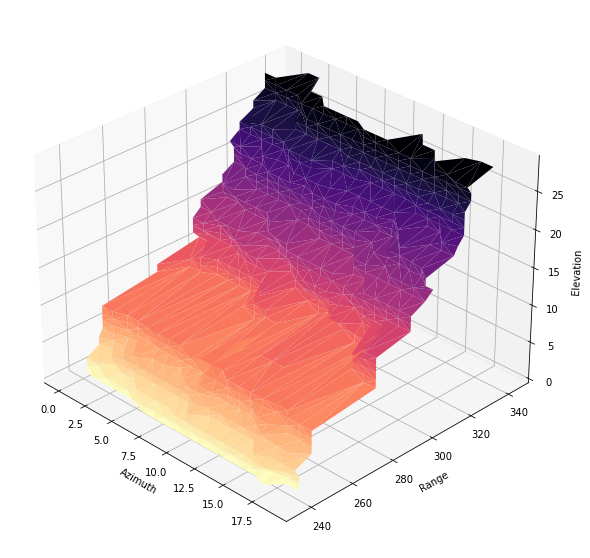

In [15]:
# postavljaju se 3D ose
figure, axis = plt.subplots(1,
                            1,
                            figsize=(10, 10),
                            subplot_kw=dict(projection='3d'))

# vrsi se i prikazuje triangulacija
d = spatial.Delaunay(coords[:, :2])
simplexes = coords[d.vertices]
coords = np.roll(coords, shift=-1, axis=1)
axis_labels = np.roll(axis_labels, shift=-1)

axis.plot_trisurf(*coords.T, triangles=d.vertices, cmap='magma_r')

# postavljaju se obelezlja osa
axis.set_xlabel(axis_labels[0])
axis.set_ylabel(axis_labels[1])
axis.set_zlabel(axis_labels[2])

# postavlja se kamera
axis.view_init(azim=-45)

# i prikazuje rezultat
plt.show()